# Obtención y analisis de los datos

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/miranda-amanda/Airbnb_Rio_de_Janeiro/refs/heads/main/listings_Rio_de_Janeiro.csv')

In [ ]:
df.head()

In [ ]:
# Seleccionando la columna "id" como clave
df.set_index('id', inplace=True)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
reviews_equal_zero = df[df['number_of_reviews'] == 0]
print(reviews_equal_zero.shape[0])

La falta valores de los códigos `license` y `neighbourhood_group` no interferirá en la analisis. Sin embargo, la cantidad de valores nulos en la variable `last_review` (8931) puede indicar que el inmueble nunca fue evaluado, ya que la variable `number_of_reviews_ltm` no tiene entradas nulas. Esto también puede ser analizado en la variable reviews_per_month, que tiene el mismo número de valores nulos. Al contar cuántas evaluaciones son iguales a cero, obtenemos el mismo número (8931), lo que indica que esos inmuebles no recibieron ninguna evaluación (review).

In [ ]:
# Reemplazar los valores nulos con 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [ ]:
# Transformar la serie 'reviews_per_month' a tipo entero
df['reviews_per_month'] = df['reviews_per_month'].astype(int)

Por último, tenemos la variable `price` con 1744 valores faltantes. El precio de la diaria es una de las variables más importantes en este tipo de conjunto de datos. Por tratarse de una pequeña proporción de datos nulos (4,7%), podríamos optar por ignorar esos datos. Sin embargo, realizaremos una imputación basada en grupos con el objetivo de crear una imputación más realista. Consideramos que los precios varían significativamente entre grupos (por barrios o tipos de habitación).

In [ ]:
df['price'] = df.groupby(['neighbourhood', 'room_type'])['price'].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Verificar la cantidad de datos nulos y los tipos de datos
df.info()

In [ ]:
# Visualizar las métricas estadísticas del DataFrame
df.describe()

## Varibles **minimum_nights, reviews_per_month e number_of_reviews_ltm**

La variable `minimum_nights` tiene algunas entradas con valores muy elevados, con un máximo de 1.000 noches.

In [ ]:
print(f'Número de registros com minimum_nights > 90: {sum(df["minimum_nights"] > 90)}')

Adoptaremos un límite máximo más razonable, como 90 noches, para asegurarnos de que las entradas sean coherentes con las expectativas de los usuarios en una plataforma como Airbnb. Dado que hay solo 73 entradas con más de 90 días como mínimo de noches, las excluiremos de nuestro análisis para garantizar que los datos sean coherentes con las expectativas para una plataforma como Airbnb.

In [ ]:
# Excluir entradas con minimum_nights mayor que 90
df = df[df['minimum_nights'] <= 90]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))

# Boxplot para minimum_nights
plt.subplot(1, 3, 1)
sns.boxplot(data=df['minimum_nights'])
plt.title('Estancias mínimas')

# Boxplot para reviews_per_month
plt.subplot(1, 3, 2)
sns.boxplot(data=df['reviews_per_month'])
plt.title('Número de reseñas por mes')

# Boxplot para number_of_reviews
plt.subplot(1, 3, 3)
sns.boxplot(data=df['number_of_reviews'])
plt.title('Número de reseñas')

plt.tight_layout()
plt.show()

#Analizando la variable **precio**.

En `df.describe()`, podemos observar que la variable price tiene un valor promedio de 712,27 reales y un valor medio de 5342,97 reales. Los valores máximos y mínimos se desvían significativamente de sus métricas centrales: 33 y 624.838,00 reales. Utilizaremos la regla del Rango Intercuartílico (IQR, por sus siglas en inglés) para establecer límites a los valores atípicos. La regla del IQR define como límite inferior la diferencia entre el primer cuartil y 1,5 * (la diferencia entre el tercer y primer cuartil). Como límite superior, se establece la suma del tercer cuartil con 1,5 * (la diferencia entre el tercer y primer cuartil).

In [ ]:
# Verificando las entradas con outliers de 'price', según la regla del IQR Score:
# La regla del IQR define como límite inferior la diferencia entre el primer cuartil y 1,5 * (la diferencia entre el tercer y el primer cuartil).
# Y como límite superior la suma del tercer cuartil con 1,5 * (la diferencia entre el tercer y el primer cuartil).

# Identificando los cuartiles:
q1 = df.price.quantile(.25)
q3 = df.price.quantile(.75)
IQR_price = q3 - q1
print('IQR de la variable price: ', IQR_price)

# Definiendo los límites inferior y superior
sup_price = q3 + 1.5 * IQR_price
inf_price = q1 - 1.5 * IQR_price

print('Límite superior de price: ', sup_price)
print('Límite inferior de price: ', inf_price)



In [ ]:
# Tratamiento de los outliers:
df_clean = df[(df['price'] >= inf_price) & (df['price'] <= sup_price)]

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df_clean['price'], bins=30, kde=True)
plt.title('Distribución de Precios sin Outliers', fontsize=16)
plt.xlabel('Precio por Noche (R$)', fontsize=12)
plt.ylabel('Número de inmuebles', fontsize=12)
plt.show()

El grafico representa la distribuición de los precios sin outliers para los inmuebles de Airbnb en Rio de Janeiro. El gráfico presenta una asimetría positiva, con una cola alargada hacia la derecha, típico en variables de precios. La mayor concencetración de precios se encuentra entre 200 y 400 reales, como era de esperarse, mientras que los valores más altos (cercanos al límite superior de 1153,75) son menos frecuentes.

La eliminación de los valores atípicos mejoró la visualización de la distribución, haciendo los datos más representativos para el análisis. La línea de densidad superpuesta muestra el comportamiento general de la variable `price`, confirmando la cola larga.

In [ ]:
print("Antes del tratamiento:")
print(df['price'].describe())

print("\nDespués del tratamiento:")
print(df_clean['price'].describe())


**Resumen de las Estadísticas:**
Antes del tratamiento, el promedio estaba fuertemente influenciado por los valores extremos (valores atípicos). La enorme variabilidad de la desviación estándar antes refleja la presencia de precios muy por encima del promedio (como el máximo de R$624.838). Este valor es un valor atípico extremo y no representa el mercado.

Después del tratamiento, el promedio se encuentra alineado con las métricas centrales (mediana y cuartiles), representando mejor el mercado. La reducción en la desviación estándar indica que los precios están más concentrados alrededor del promedio, sin la distorsión de valores atípicos. El valor máximo de 1.152 reales corresponde al límite superior definido por el IQR y se encuentra dentro del rango razonable para precios de hospedaje. Los valores de los cuartiles (25%, 50%, 75%) ahora son más consistentes con el mercado, lo que sugiere que los precios generalmente varían entre 200 y 490 reales, con una mediana de 300 reales.

El tratamiento de los valores atípicos hizo que los datos fueran más representativos, evitando la distorsión de las métricas por valores extremos. La reducción en la desviación estándar y en el promedio refleja la exclusión de propiedades con precios anormalmente altos.

In [ ]:
#Histograma de las variables numéricas:

histogramas = df_clean.drop(columns=['host_id', 'neighbourhood_group', 'license'])
histogramas.hist(bins=100, figsize=(15,10));


Las distribuciones de la **latitud y longitud** indican que las propiedades están concentradas en áreas geográficas específicas, con poca variación.

Después del tratamiento, la variable **precio** muestra una distribución asimétrica positiva, con mayor frecuencia en precios más bajos (entre 100 y 400 reales). Esto es consistente con el hecho de que la mayoría de los anuncios tienen precios accesibles.

La mayoría de las propiedades tiene **estancias mínimas** muy cortas, menor que 5 días. La cola larga indica que algunos anuncios tienen estancias mínimas mucho más altas.

La mayoría de los anuncios recibió pocas **reseñas** (concentradas entre 0 y 10). La cola larga muestra que algunas propiedades tienen cientos de reseñas. Además, la mayoría de las propiedades tienen pocas **reseñas mensuales**, con la mayor frecuencia cerca de 0.

La mayoría de los anfitriones tienen pocas propiedades listadas (valores bajos). Algunos pocos anfitriones tienen un gran número de propiedades, lo que puede indicar empresas disponibilizando inmuebles o inversores de imuebles.

La variable de disponibilidad muestra picos en 0, 180 y 365 días, lo que indica propiedades no disponibles, disponibles por medio tiempo o disponibles todo el año.

Similar al número de reseñas, la variable "número de reseñas del último año" presenta una concentración en valores bajos (de 0 a 20 reseñas en el último año).

In [ ]:
# Definiendo la matriz de correlación
corr = df_clean[['price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm']].corr()

display(corr);

In [ ]:
# Heatmap para una mejor visualización de las correlaciones
plt.figure(figsize=(8,4))
plt.title('Correlación')
sns.heatmap(corr, cmap='coolwarm', fmt='.2f', square=True, linecolor='white', annot=True);

In [ ]:
plt.figure(figsize=(8, 4))
bins = [0, 200, 600, 1153.75]
labels = ['Bajo', 'Medio', 'Alto']
df_clean.loc[:, 'price_category'] = pd.cut(df_clean['price'], bins=bins, labels=labels)

df_clean['price_category'].value_counts().plot(kind='bar')
plt.title('Distribución por Rango de Precio')
plt.xlabel('Rango de Precio')
plt.ylabel('Número de Inmuebles')
plt.show()


In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_clean, x='room_type', y='price')
plt.title("Variación de Precio por Tipo de Alojamiento")
plt.xlabel("Tipo de Alojamiento")
plt.ylabel("Precio por Noite (R$)")
plt.show()

In [ ]:
# Visualizando inicialmente la cantidad de cada tipo de inmueble y su porcentaje en relación con el dataset:
df_clean.room_type.value_counts()/df_clean.shape[0]


La mayor parte del conjunto de datos se concentra en alojamientos completos (casas/departamentos) y habitaciones privadas. En cambio, las habitaciones compartidas y las habitaciones de hotel representan aproximadamente solo el 1 % del total.

In [ ]:
# Agrupar el precio promedio por tipo de alojamiento
price_by_room_type = df_clean.groupby('room_type')['price'].mean().sort_values(ascending=False)
print("Precio promedio por tipo de alojamiento:")
print(price_by_room_type)

# Visualizar en gráfico de barras
price_by_room_type.plot(kind='bar', figsize=(8, 4))
plt.title('Precio promedio por Tipo de alojamiento', fontsize=14)
plt.xlabel('Tipo de alojamiento', fontsize=12)
plt.ylabel('Precio promedio (R$)', fontsize=12)
plt.xticks(rotation=0)
plt.show()


Los alojamientos más caros son los hoteles y las casas/departamentos enteros, mientras que los más económicos son las habitaciones compartidas. Las habitaciones privadas presentan un precio inferior al de las habitaciones de hotel.

In [ ]:
#Cantidad de inmuebles por barrio:
df_clean.neighbourhood.value_counts().sort_values(ascending=False)

Es posible afirmar que la mayoría de los alojamientos se encuentran en los barrios de Copacabana, Barra da Tijuca e Ipanema.

In [ ]:
# Top 10 barrios con mayor cantidad de inmuebles "hotel room"
hotel_room = df_clean[df_clean['room_type'] == 'Hotel room']
hotel_room_dist = hotel_room['neighbourhood'].value_counts(normalize=True).head(10)

hotel_room_dist.plot(kind='bar', figsize=(8, 4))
plt.title('Habitaciones de Hoteles en los 10 Principales Barrios', fontsize=14)
plt.xlabel('Barrio', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Top 10 barrios con mayor cantidad de inmuebles "Entire home/apt"
entirehomeapt_room = df_clean[df_clean['room_type'] == 'Entire home/apt']
entirehomeapt_room_dist = entirehomeapt_room['neighbourhood'].value_counts(normalize=True).head(10)

entirehomeapt_room_dist.plot(kind='bar', figsize=(8, 4))
plt.title('Distribución de Casas o Apartamentos en los 10 Principales Barrios', fontsize=14)
plt.xlabel('Barrio', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Top 10 barrios con mayor cantidad de inmuebles "Private room"
private_room = df_clean[df_clean['room_type'] == 'Private room']
private_room_dist = private_room['neighbourhood'].value_counts(normalize=True).head(10)

private_room_dist.plot(kind='bar', figsize=(8, 4))
plt.title('Distribución de Habitaciones Privadas en los 10 Principales Barrios', fontsize=14)
plt.xlabel('Barrio')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Top 10 barrios con mayor cantidad de inmuebles "Shared room"
shared_room = df_clean[df_clean['room_type'] == 'Shared room']
shared_room_dist = shared_room['neighbourhood'].value_counts(normalize=True).head(10)

shared_room_dist.plot(kind='bar', figsize=(8, 4))
plt.title('Distribución de Habitaciones Compartidas en los 10 Principales Barrios', fontsize=14)
plt.xlabel('Barrio', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Inicialmente, verifiquemos la media de precio para cada barrio:
df_clean.groupby(['neighbourhood']).price.mean().sort_values(ascending=False)

In [ ]:
#Inmuebles por latitud y longitud:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x=df_clean['longitude'], y=df_clean['latitude'], c=df_clean['price'], cmap='coolwarm', alpha=0.25, s=8)

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución Geográfica de Alojamientos según Precio', fontsize=14)
cbar = plt.colorbar(scatter)
cbar.set_label('Precio (R$)')
plt.show()

Bairro Latitude Longitude

Copacabana	-22.96599	-43.17940

In [ ]:
expensive = df_clean[df_clean.price > 800]
expensive.neighbourhood.value_counts().sort_values(ascending=False)/expensive.shape[0]

In [ ]:
# Trazando las coordenadas de los alojamientos más caros:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x=expensive['longitude'], y=expensive['latitude'], c=expensive['price'], cmap='coolwarm', alpha=0.75, s=20)

plt.title('Ubicación de los Alojamientos Más Caros', fontsize=14)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label('Precio (R$)')
plt.show()

Para que tengamos una idea de a qué barrio nos referimos al tratar de latitud y longitud, agrupamos por la mayor cantidad de inmuebles disponibles en los barrios, con sus respectivas latitudes y longitudes.

In [ ]:
# Agrupar por barrio y contar la cantidad de inmuebles, latitud y longitud
top_neigh_by_price = (df_clean.groupby('neighbourhood').agg({'price': 'count', 'latitude': 'mean','longitude': 'mean'})
    .sort_values(by='price', ascending=False).head(10).reset_index())
print(top_neigh_by_price)

Ahora, analizaremos visualmente la relación entre el precio de los inmuebles y la cantidad de reseñas en la plataforma. Como la cantidad es elevada, dividimos en rangos de reseñas.

In [ ]:
#Rangos de número de reseñas
bins = [0, 10, 25, 50, 100, 200, 300, float('inf')]
labels = ['0-10', '11-25', '26-50', '51-100', '101-200', '201-300', '300+']

In [ ]:
#Creado totalmente por chatgpt
# Convertir explícitamente a categoría antes de asignar
reviews_categories = pd.cut(df_clean['number_of_reviews'], bins=bins, labels=labels, right=False).astype('category')

# Asignar a la columna con el dtype correcto
df_clean = df_clean.copy()  # Asegurarnos de no estar trabajando en una vista
df_clean['reviews_range'] = reviews_categories

# Agrupar por rangos (con observed=True para evitar warning futuro)
price_by_reviews_range = df_clean.groupby('reviews_range', observed=True)['price'].mean().sort_values(ascending=False)
print(price_by_reviews_range)

In [ ]:
# Visualización
price_by_reviews_range.plot(kind='bar', figsize=(8, 4))
plt.title('Precio Promedio por Rango de Reseñas', fontsize=14)
plt.xlabel('Rango de Reseñas', fontsize=12)
plt.ylabel('Precio Promedio (R$)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Relação entre Preço e minímo de noites para aluguel

In [ ]:
mean_price_5night = df_clean[df_clean.minimum_nights <= 10]
mean_price_5night['price'].dropna().mean()

El valor promedio de 370.12 para alojamientos con estadía mínima de hasta 10 días sugiere que los inmuebles de corta estadía tienden a tener un precio más accesible o más competitivo, posiblemente porque son más buscados por turistas o personas que viajan por trabajo.

In [ ]:
# Verificando la media del precio de la diaria que requieren una estancia mínima entre 25 y 35 días:
mean_price_30night = df_clean[df_clean.minimum_nights<=35]
mean_price_30night = mean_price_30night[mean_price_30night.minimum_nights>25]
mean_price_30night.price.mean()

El valor de 416.25 para estadías más largas sugiere que los inmuebles con una estadía mínima entre 25 y 35 días tienden a tener un precio más alto.

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='number_of_reviews', y='price', alpha=0.4, s=20)
sns.regplot(data=df_clean, x='number_of_reviews', y='price', scatter=False, color='red')

plt.title('Relación entre Número de Reseñas y Precio', fontsize=16)
plt.xlabel('Número de Reseñas', fontsize=12)
plt.ylabel('Precio por Noche (R$)', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
sns.boxplot(x='room_type', y='availability_365', data=df_clean)
plt.title("Disponibilidad por Tipo de Alojamiento")
plt.xlabel("Tipo de Alojamiento")
plt.ylabel("Disponibilidad por año")
plt.show()

#Comparando Disponibilidad vs. Precio Promedio


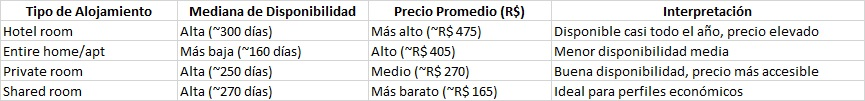

A partir de la comparación entre la disponibilidad de los alojamientos y su precio promedio, es posible observar que las habitaciones de hotel son las más caras y también las más disponibles, lo que refuerza su perfil de operación profesional. Las casas o apartamentos enteros tienen una disponibilidad media menor, lo que puede indicar que tengan una alta tasa de ocupación, lo que agota rápidamente las fechas disponibles, o bien, el anfitrión restringe intencionalmente los días disponibles, ya sea por uso personal o como parte de una estrategia. Las habitaciones privadas representan una buena alternativa: tienen una alta presencia en la plataforma, con un precio más accesible y buena disponibilidad. Las habitaciones compartidas son poco comunes, pero resultan ser las más accesibles y con buena disponibilidad.

In [ ]:
bins = [0, 90, 180, 270, 365]
labels = ['0-90 dias', '91-180 dias', '181-270 dias', '271-365 dias']

df_clean['availability_range'] = pd.cut(df_clean['availability_365'], bins=bins, labels=labels, right=True)


In [ ]:
avg_reviews_by_avail = df_clean.groupby('availability_range', observed=True)['number_of_reviews'].mean().sort_values(ascending=False)
print(avg_reviews_by_avail)

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x=avg_reviews_by_avail.index, y=avg_reviews_by_avail.values)
plt.title("Promedio de Reseñas por Rango de Disponibilidad")
plt.xlabel("Rango de Disponibilidad (días/año)")
plt.ylabel("Número Promedio de Reseñas")
plt.tight_layout()
plt.show()

Los alojamientos con disponibilidad entre 91 y 180 días son, en promedio, los que acumulan más evaluaciones. Curiosamente, aquellos con mayor disponibilidad (181 a 365 días) presentan menos evaluaciones, lo que contradice la idea de que estar más tiempo disponible implica ser más alquilado.

Las propiedades con menor disponibilidad (hasta 180 días) parecen tener una mayor rotación y ocupación. Una posible interpretación es que estar más disponible no necesariamente significa ser más atractivo para los huéspedes —podría deberse a precios elevados, ubicación menos deseada o menor calidad del alojamiento.

En cambio, aquellos alojamientos con menos días disponibles pero muchas evaluaciones sugieren una alta demanda.


#Conclusión


Este proyecto de análisis exploratorio del mercado de alojamientos de Airbnb en Río de Janeiro buscó obtener insights importantes sobre el comportamiento de los precios, la dinámica de las reseñas y la disponibilidad de los inmuebles en esta ciudad brasileña, super turística y reconocida a nivel mundial. A continuación, algunas conclusiones según los objetivos planteados:

1. Distribución de precios según el tipo de habitación y la ubicación
Los precios presentan una distribución asimétrica positiva, con la mayoría de las propiedades concentradas entre 200 y 400 reales por noche. Fueron eliminados los valores atípicos para una observasión más realista del mercado. Se evidenció que tanto el tipo de habitación como el barrio influyen significativamente en el precio: habitaciones privadas suelen tener precios más bajos en comparación con departamentos o alojamientos enteros, y barrios turísticos o centrales tienden a tener precios más elevados, como el barrio de Copacabana. La mayoría de los alojamientos también se encuentran en este barrio, excepto los hoteles, que están más presentes en el centro de la ciudad.

2. Relación entre el número de reseñas y el precio
La mayoría de los inmuebles tiene pocas reseñas, y se identificó una ligera correlación negativa entre el número de reseñas y el precio. Esto puede indicar que alojamientos más económicos tienden a recibir más evaluaciones, posiblemente por tener mayor rotación de huéspedes. Esto queda más relevante cuando observamos que estos imuebles tienem una disponibilidad más baja. Sin embargo, la correlación no es lo suficientemente fuerte como para establecer una relación causal directa.

3. Factores que afectan la disponibilidad de los inmuebles
La variable `availability_365` mostró picos en 0, 180 y 365 días, indicando distintos perfiles de uso: propiedades no disponibles, de uso parcial o totalmente disponibles durante el año. Además, se observó que la disponibilidad se relaciona moderadamente con el número de reseñas recientes, lo que puede indicar una mayor ocupación y rotación de huéspedes.

El análisis de los datos de Airbnb en Río de Janeiro permitió identificar patrones importantes en cuanto a precios, tipo de alojamiento y disponibilidad. Estos hallazgos pueden ser útiles para  los anfitriones optimizaren sus anuncios, así como para potenciales huéspedes interesados en comprender mejor el comportamiento del mercado local. Futuras investigaciones podrían incorporar variables temporales (como eventos locales o temporadas altas) para enriquecer aún más la comprensión del mercado del Airbnb en la cuidad de Rio de Janerio.